
# Projection Methods


we implement the following projection methods. In particular we will look at:



1.   Principle component analysis (PCA)
2.   Singular value decomposition (SVD)
3.   Non-Negative Matrix Factorization (NMF)



Matrix factorization methods are a type of mathematical technique used to decompose a matrix into the product of smaller matrices. This process helps break down a complex matrix into simpler constituent parts, making it easier to perform more advanced matrix operations. These methods serve as the foundation of linear algebra in computer science, enabling fundamental tasks like solving linear equations, calculating inverses, and determining the determinant of a matrix.

In the context of machine learning, we primarily employ matrix factorization for dimensionality reduction. This means reducing the number of features in a dataset to facilitate supervised and unsupervised learning tasks and aid visualization.


In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.datasets import fetch_openml

Lets first load some data. We will use the mnist dataset again for this problem.

In [2]:
# loading images
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

c:\Users\44746\anaconda3\envs\tf\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
images = images.to_numpy()

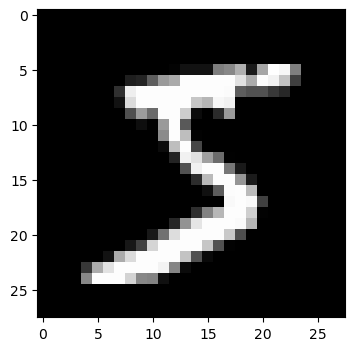

In [4]:
# plot the first image
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');

We now look to preprocess.

The steps below ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).


The preprocessing steps we will do are:
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.

In [5]:
# Some preprocessing of the data

# we take the first 1000 images
n_datapoints = 1000

# reshaping and taking a slice of the data
X = (images.reshape(-1, 28 * 28)[:n_datapoints]) / 255.

The next two steps of the preprocessing is:

2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

In [6]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [7]:
X = standardise(X)

# 1. PCA

Now we will implement PCA. We assume that we are performing PCA on
some dataset $\boldsymbol X$ for $k$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.





In [8]:

from scipy.sparse import linalg

def pca_function(X,k):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors) 

    return X_pca, eigenvectors, eigenvalues

Lets now apply our PCA function to create three principle components, k=3.

In [9]:
# choose our number of principal components
k=3
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 
eigenvalues

array([39.59185485, 33.42155067, 27.83715875])

Text(0, 0.5, 'Eigenvalue')

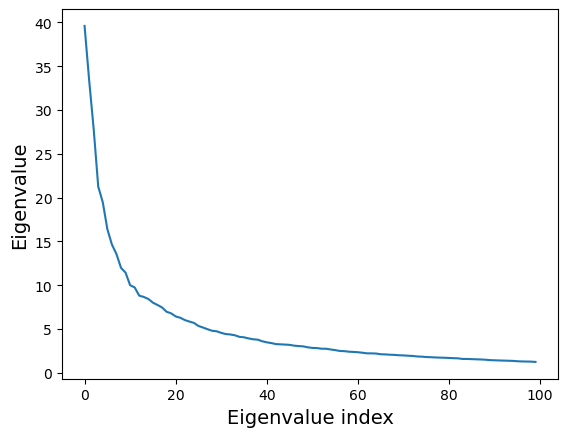

In [10]:
k=100
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 
plt.plot(eigenvalues);
plt.xlabel('Eigenvalue index',fontsize=14)
plt.ylabel('Eigenvalue',fontsize=14)

Text(0, 0.5, 'Density')

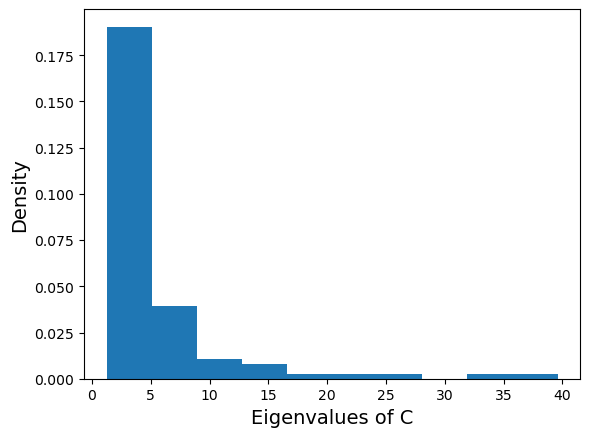

In [11]:
## If we look at the spectrum, the large values indicate there is 
## some signal of significant correlations
plt.hist(eigenvalues, density=True);
plt.xlabel('Eigenvalues of C',fontsize=14)
plt.ylabel('Density',fontsize=14)

Lets now plot our original images projected onto a 2d plane

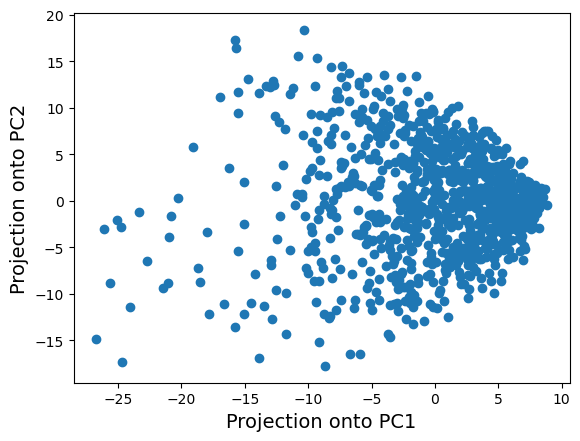

In [12]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel('Projection onto PC1',fontsize=14)
plt.ylabel('Projection onto PC2',fontsize=14)
plt.show()

Lets now compute the variance in each principle component. Then print the variance for the first three principle components.

In [13]:
k=3
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 

C = 1.0/(len(X)-1) * np.dot(X.T, X)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance 
print('The explained variance for the first three principle components is: {}'.format(explained_variances))

The explained variance for the first three principle components is: [0.06494624 0.05482451 0.04566391]


Lets now repeat this using the sklearn PCA function to confirm we have done it correctly.

The visual might be inversed but the relative distances between points is consistent.

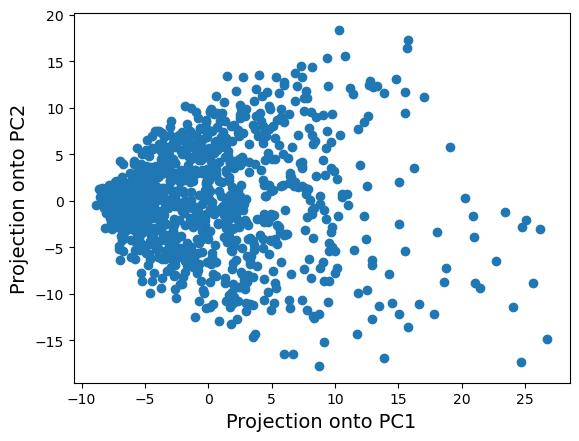

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k, svd_solver='full')
X_sk_pca = pca.fit_transform(X)
plt.scatter(X_sk_pca[:,0],X_sk_pca[:,1])
plt.xlabel('Projection onto PC1',fontsize=14)
plt.ylabel('Projection onto PC2',fontsize=14)
plt.show()

In [15]:
pca.explained_variance_ratio_

array([0.06494624, 0.05482451, 0.04566391])

Lets now try and understand what these different principle components represent for a given image!

Lets plot the first 25 eigenvectors reshaped into their original image size.


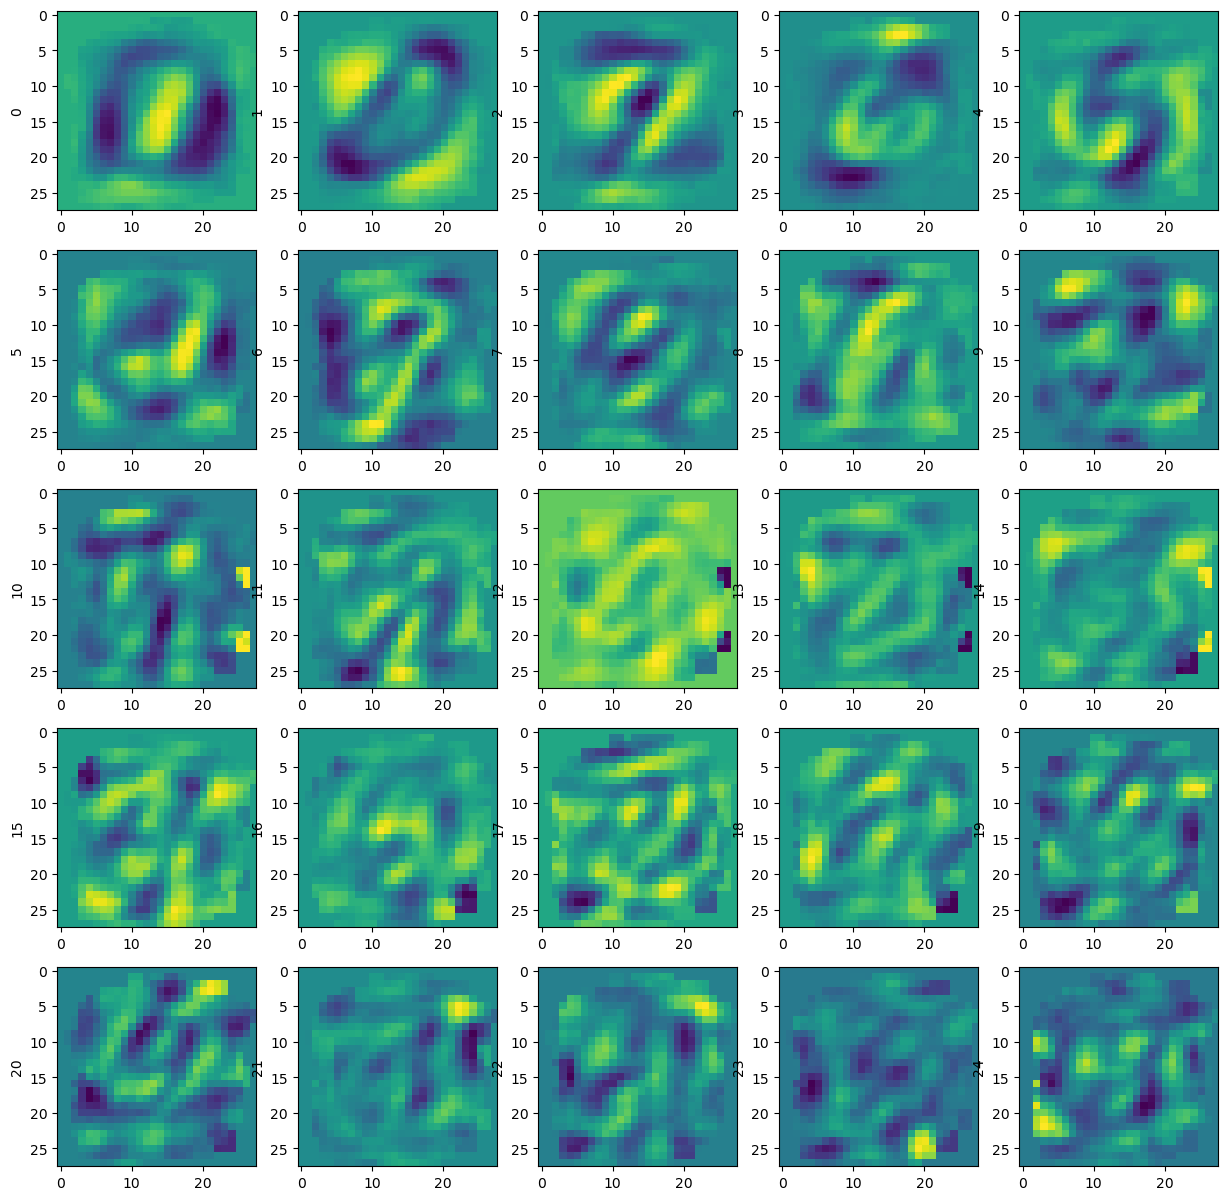

In [16]:
k = 25
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 

nrow = 5; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))

# 2. SVD

We now want to perform a singular value decomposition of our data,

$$
\mathbf X = \mathbf U \mathbf S \mathbf V^\top
$$



where $\mathbf U$ is the unitary matrix, $\mathbf S$ is the diagonal matrix of singular values $s_i$, and  $\mathbf V$ are the principal directions/axes.

We can see a link with PCA at this moment; we can compute the covariance matrix as,

$
\mathbf C = \mathbf V \mathbf S \mathbf U^\top \mathbf U \mathbf S \mathbf V^\top /(n-1) = \mathbf V \frac{\mathbf S^2}{n-1}\mathbf V^\top,
$



which confirms that $\mathbf V$ are the principal directions/axes, and the columns of $\mathbf U \mathbf S$ are our principal components. The singular values $\lambda_i = s_i^2/(n-1)$ correspond to the eigenvalues.


We can define our principal components explicitly as,


$\mathbf X \mathbf V = \mathbf U \mathbf S \mathbf V^\top \mathbf V = \mathbf U \mathbf S$







In [17]:

# use the SVD algorithm from sklearn
U, s, V = sc.linalg.svd(X)

Now compute the project of the features X by dot product with the principal axes V.

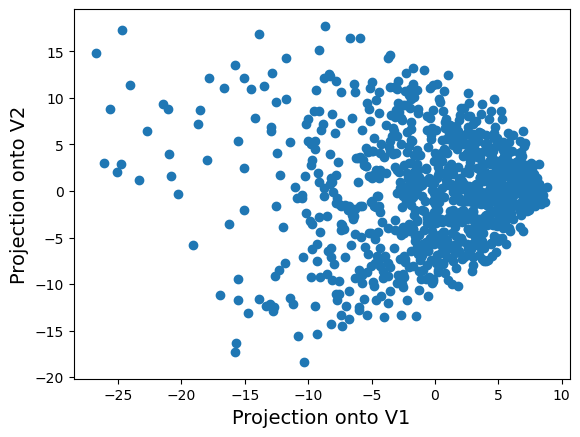

In [18]:
# given our decomposition, create the projection of our features X by dot product with the principle axes V

X_svd = X.dot(V.T)
plt.scatter(X_svd[:,0],X_svd[:,1])
plt.xlabel('Projection onto V1',fontsize=14)
plt.ylabel('Projection onto V2',fontsize=14)
plt.show()

To confirm that we have performed the projection correctly, lets use the [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) function from sklearn.

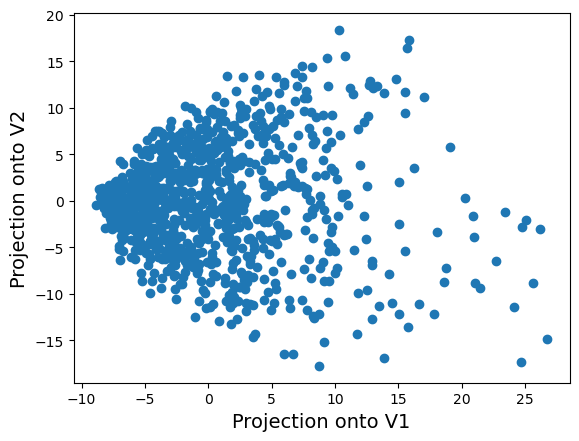

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)
plt.scatter(X_svd[:,0],X_svd[:,1])
plt.xlabel('Projection onto V1',fontsize=14)
plt.ylabel('Projection onto V2',fontsize=14)
plt.show()

# 3. NMF

Now we will look at non-negative matrix factorisation. NMF is a matrix factorization method where we constrain the matrices to be nonnegative. PCA previously produced factors that could be both positive and negative. 

NMF factors our n-by-m feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (n-by-k) and $\mathbf H$ (k-by-m). The factorization is not exact. $\mathbf W\mathbf H$ is a lower-rank approximation to $\mathbf A$. The factors $\mathbf W$ and $\mathbf H$ minimize the root mean square residual D between $\mathbf X$and $\mathbf W\mathbf H$.

Note that for non-negative matrix factorisation we require the input matrix to be non-negative. Therefore, we must normalise between 0 and 1 instead of standard normalise which we used for PCA and SVD.

Here we will use Lee and Seung's multiplicative update rule. 


$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$


and


$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$


until $\mathbf{W}$ and $\mathbf{H}$ are stable. It is important to note that updates are done on an element by element basis and not matrix multiplication.

In [20]:
# normalise min max to 0-1
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

In [21]:
## Redefine the matrix X before applying a new normalization ##

# we take the first 1000 images
n_datapoints = 1000

# reshaping and taking a slice of the data
X = (images.reshape(-1, 28 * 28)[:n_datapoints]) / 255.

X = normalize_nmf(X)

An optimisation needs an objctive (or 'cost') function to minimize. The two most standard objective functions are the ones analyzed by Lee and Seung in:
https://papers.nips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf

The first is the square of the Euclidean distance between the data $X$ and the product $WH$:


$
||X - WH||^2 = \sum_{ij}(X_{ij} - (WH)_{ij})^2
$


Another version of loss function based on the Euclidean distance is the following:


$
\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{n}
$


where d is the difference $d = X - WH$, and e is a vector of all ones where $e^⊤ K e$ simply performs a sum over all elements in K, and $n$ is the total number of elements in $X$. The symbol $\odot$ is the element wise product (Hadamard product).

The second type of loss function analyzed by Lee and Seung is a type of divergence defined as:

$
D(X||WH) = \sum_{ij}\left[X_{ij} \log\left(\frac{X_{ij}}{(WH)_{ij}}\right) - X_{ij} +(WH)_{ij}\right]
$


In [22]:
# lets define a cost matrix to compare the difference
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 
    
    # Compute the Euclidean distance-based objective function
    cost_value = (diff * diff).sum() / (X.shape[0]*X.shape[1]) 
    
    # Here we have also normalized the sum by the nummber of terms in the sum (but it's not necessary).
    
    return cost_value

Now implement Lee and Seung's multiplicative update rule. First implement the update on H and then the update on W, finally compute the objective function. Note that this should be done on an element by element basis, but here we are using matrix multiplication which isn't exactly the same.

In [23]:
# choosing the number of dimensions (r, called here k) on which to project
k = 2

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))

    # compute the update on W
    W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) 

    # compute the cost and append to list
    cost_values.append(cost(X,W,H))

We should next check to confirm that we have converged to a solution by plotting the value of our objective function over the iterations.

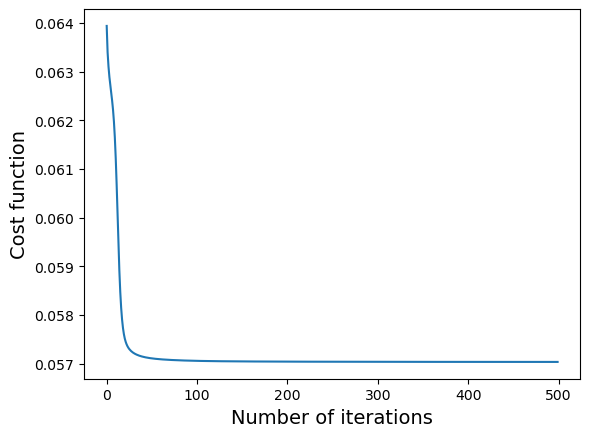

In [24]:
# plotting the cost
plt.plot(cost_values)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

We can see above that we have converged in optimising our NMF according to the Euclidean distance objective function. Also the chi2 version of this loss gives us a similar result.

In [25]:
# lets define a cost matrix to compare the difference
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1]) 
    
    return chi2

# choosing the number of dimensions (r, called here k) on which to project
k = 2

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count)) 

    # compute the update on W
    W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))

    # compute the cost and append to list
    cost_values.append(cost(X,W,H))

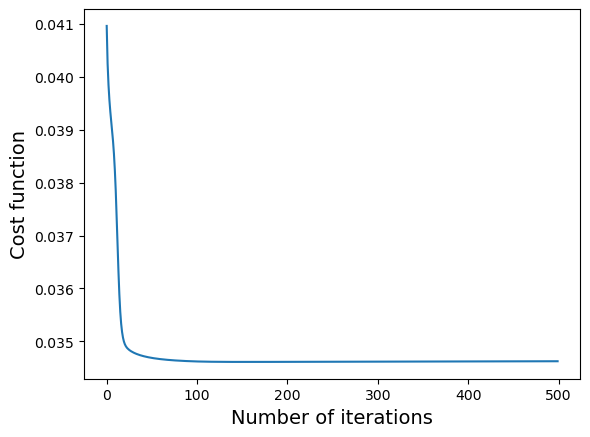

In [26]:
# plotting the cost
plt.plot(cost_values)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

Finally, we repeat the optimization with a different objective function, the divergence $D$.

In [27]:
# lets define a cost matrix to compare the difference
def cost(X,W,H):
    
    ## we add a small epsilon to avoid ill-defined divisions/log
    eps = 0.0001
    
    # compute the divergence term by term
    term = X*np.log(np.divide(X,np.dot(W, H)+ eps) + eps) - X + np.dot(W, H) 

    # sum over the terms
    cost_value = term.sum()/ (X.shape[0]*X.shape[1])
    # Here we have also normalized the sum by the nummber of terms in the sum (but it's not necessary).
    
    return cost_value

# choosing the number of dimensions (r, called here k) on which to project
k = 2

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.0001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count)) 

    # compute the update on W
    W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) 

    # compute the cost and append to list
    cost_values.append(cost(X,W,H))

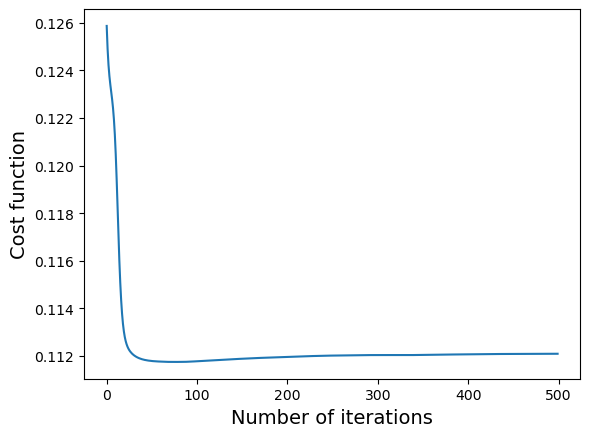

In [28]:
# plotting the cost
plt.plot(cost_values)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

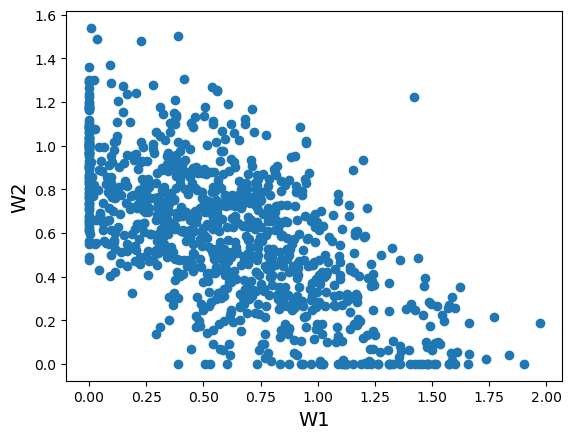

In [29]:
plt.scatter(W[:,0],W[:,1])
plt.xlabel('W1', fontsize=14)
plt.ylabel('W2', fontsize=14)
plt.show()